This notebook is meant to help recording and organizing the work toward a clean bias-variance curve

### Workflow

1. Simulation
2. Analyis
3. Observations
4. Debugging
5. Fixes and Parameter Tuning
6. Repeat


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ring_attractor import RingAttractor

# Batch 2

### 1. Simulation

>   "neurons_n": 256, 
    "simulation_time": 10000,  
    "iterations": 10,  
    "noise_levels": 80,  
    "noise_low": 0.0,  
    "noise_high": 8e-4,  
    "weights": [0.050, 0.100, 0.050, 0.250],  
    "fixed_points": [0, 1, 2, 4, 8, 16, 32]



In [2]:
df = pd.read_csv('backups/batch_2/means.csv', index_col=0)
df

,0.00e+00,1.01e-05,2.03e-05,3.04e-05,4.05e-05,5.06e-05,6.08e-05,7.09e-05,8.10e-05,9.11e-05,...,7.09e-04,7.19e-04,7.29e-04,7.39e-04,7.49e-04,7.59e-04,7.70e-04,7.80e-04,7.90e-04,8.00e-04
0,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,...,48.767473,69.730107,30.821029,42.408338,25.386936,19.316285,20.923188,20.495432,18.611340,23.621443
1,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,...,48.767473,69.730107,30.821029,42.408338,25.386936,19.316285,20.923188,20.495432,18.611340,23.621443
2,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,...,48.767473,69.730107,30.821029,42.408338,25.386936,19.316285,20.923188,20.495432,18.611340,23.621443
4,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,...,49.352432,69.730107,30.821029,42.408338,25.048267,19.316285,20.300855,20.495432,18.611340,23.621443
8,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,...,49.278641,68.169569,29.829807,40.594308,22.964160,21.759978,35.744489,20.809169,20.254835,21.249990
16,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,5.964097,...,58.968820,27.447100,43.204475,58.910424,27.641944,43.560909,43.272239,27.335846,27.561343,27.543482
32,6.328125,6.328125,6.328125,6.374986,6.449688,6.529994,6.476268,6.491305,6.501856,6.491305,...,23.139061,23.235746,22.806860,23.126684,22.875411,23.285690,23.083362,23.077239,23.151082,23.213364


### 2. Analysis

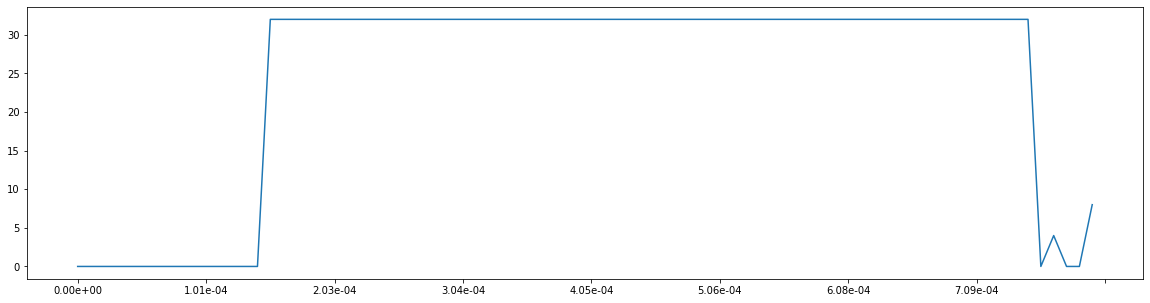

In [3]:
fig = plt.figure(figsize=(20,5))
df.idxmin().plot()

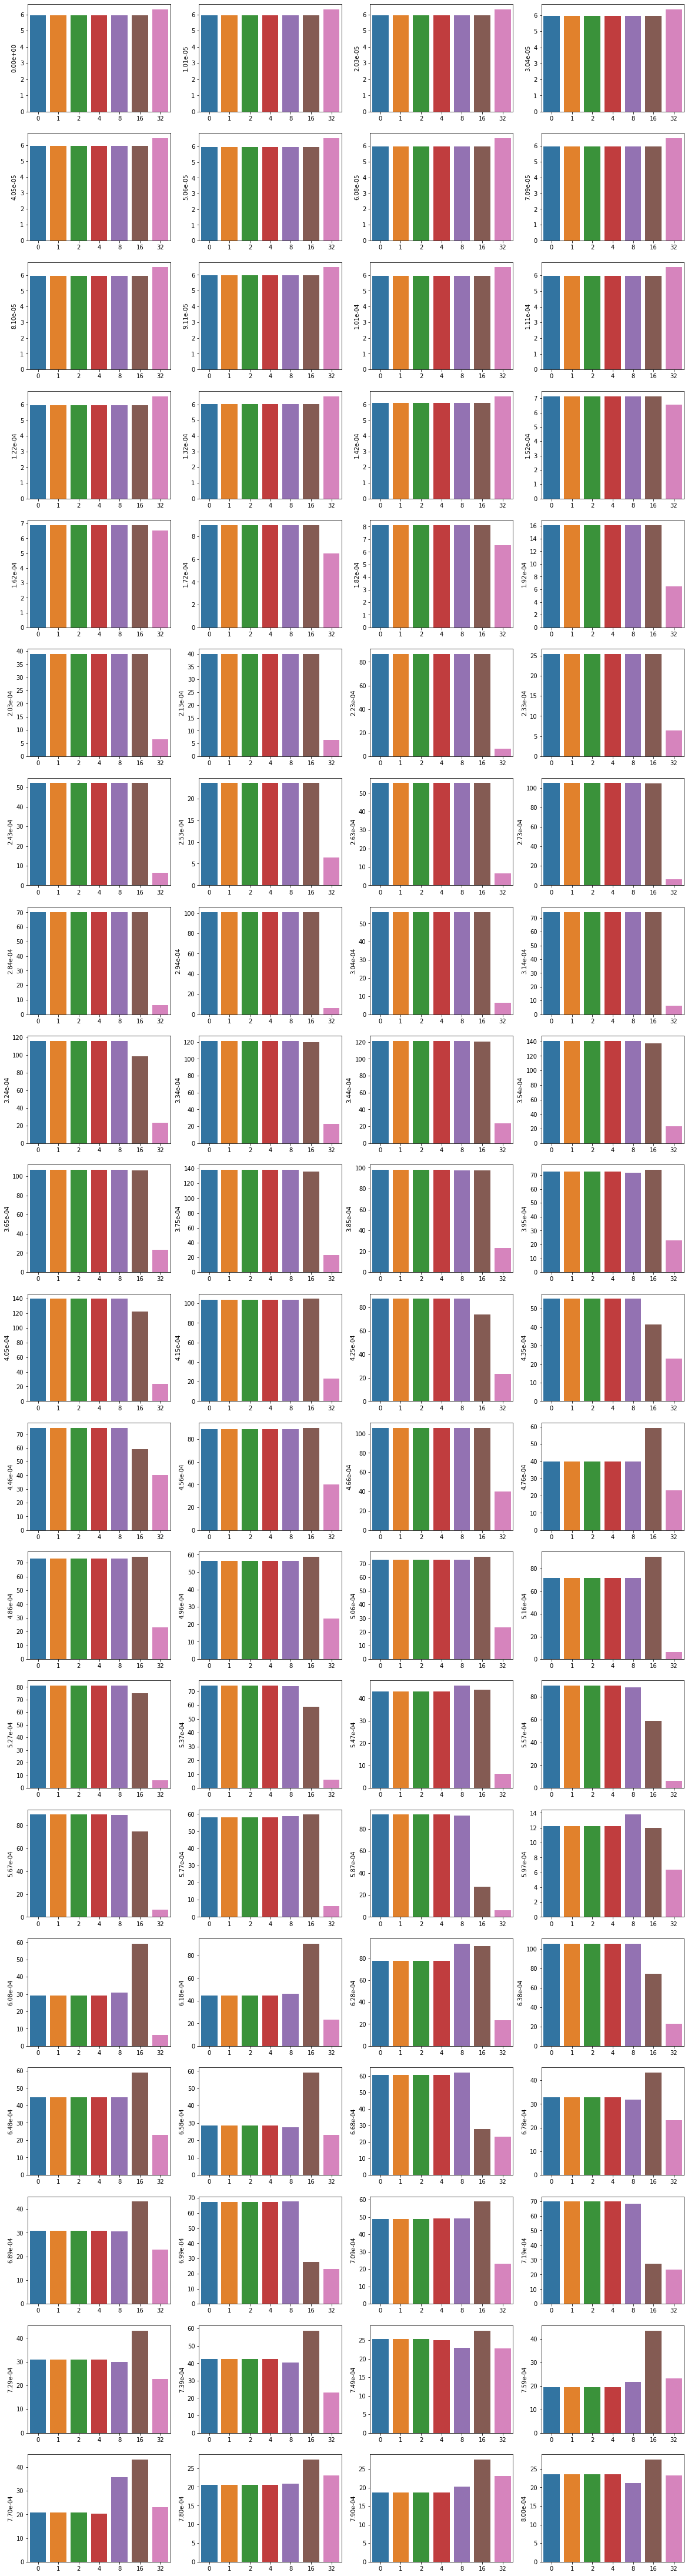

In [4]:
_, axes = plt.subplots(20, 4, figsize=(20, 80))
c, r = 0, 0
for col in df.columns:
    sns.barplot(x=df.index, y=col, data=df, ax=axes[c, r])
    # same scale, log if its disappearing
    
    r += 1
    if r > 3:
        c+=1
        r=0

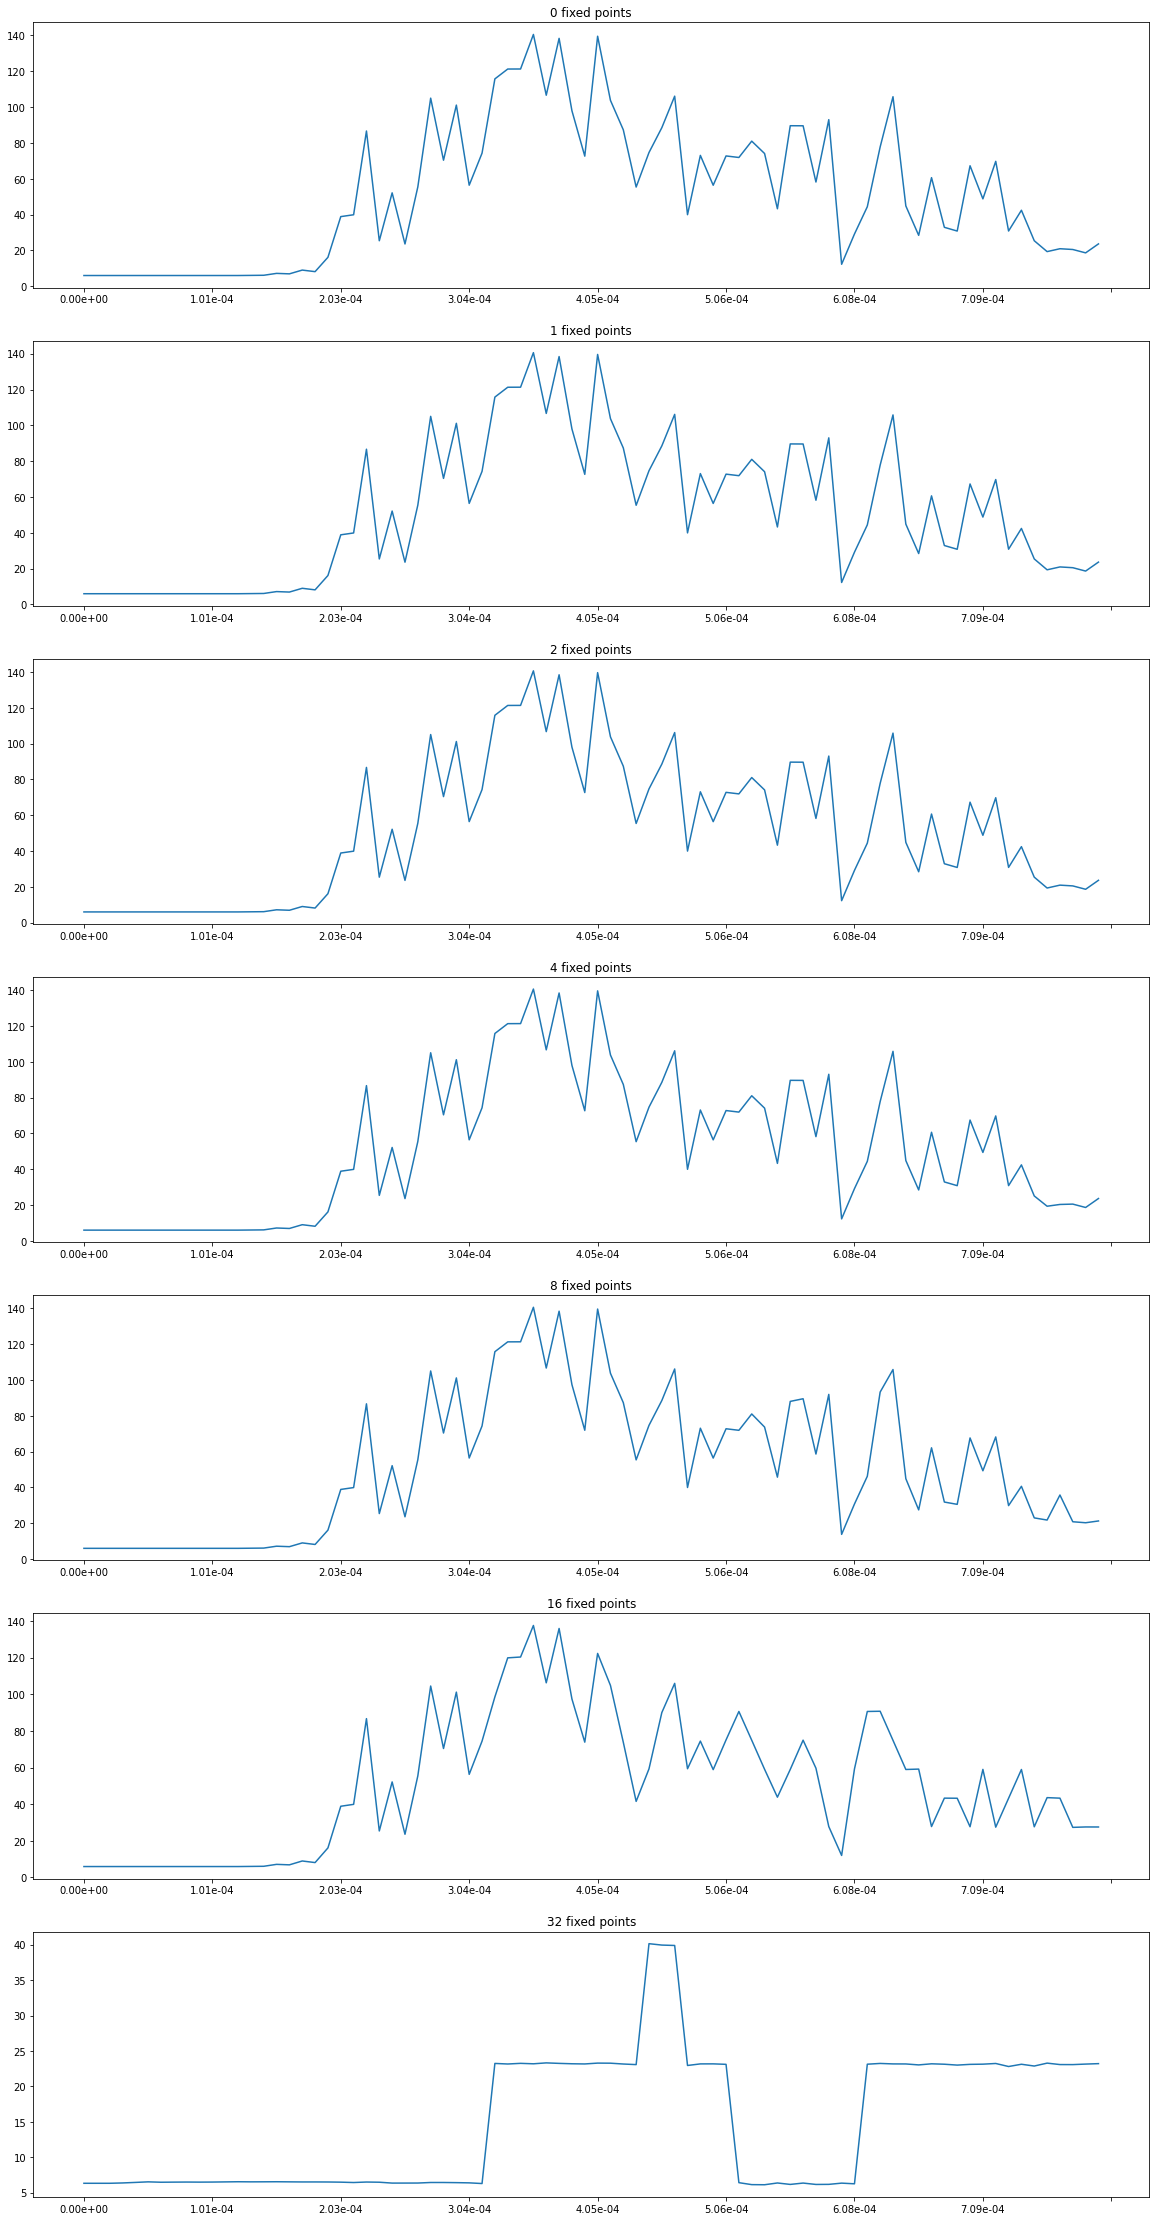

In [5]:
fig, axes = plt.subplots(7, 1, figsize=(20,40))

for i, k in enumerate([0,1,2,4,8,16,32]):
    axes[i].set_title(f"{k} fixed points")
    df.loc[k].plot(ax=axes[i])

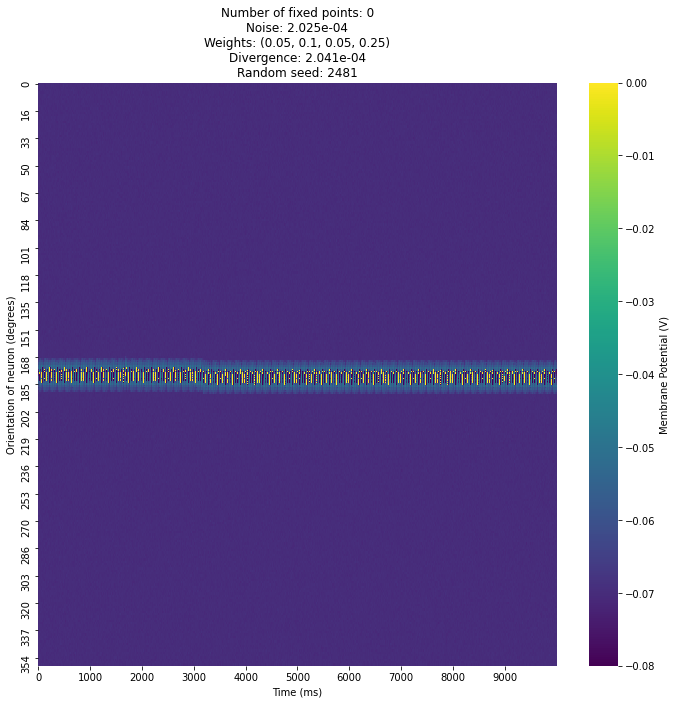

In [6]:
# Looking for suspitious values: with the old metric the error was really high
noises = np.linspace(0, 8e-4, 80)
ring = RingAttractor(n=256, noise=noises[20],
                     fixed_points_number=0, 
                     time=10000, random_seed=2481, plot=True)

error = ring.simulate()


### 3. Observations

    a. The errors are practically identical for all numbers of fixed points apart from 32. This could be due to the drift never reaching the fixed points (check)
    
    b. At some point looks like that the 16 fp setup is working, but then it perform worst than others. This makes no sense, unless the other fixed points are closer to the starting point, which shouldn't be. This could be due to the drifts actually having a lot of variance but randomly going back to the starting point.
    
    c. The error for 32 fp are step-shaped, probably a lot of noise is able to drift the bump away from the fixed point. The fact that in the end it comes back suggests that 10 is not enough trials, and we need to average over more.
    
  
    
### 4. Debugging

Probably there is some bug with how the error metric is being computed. Furthermore, the bare mean is not informative enough, so we'll change the metric


### 5. Fixes

The new metric will be calculated as follows, taking the KL divergence between the two Von Mises distributions fitted respectevely on the first and second half of the bump:

>>>        df = pd.DataFrame(potentials)
        df.index = [self.neurons[i].angle for i in df.index]
        spikes = df == 0.0

>>>        spikes = spikes.astype(int)
        spikes = spikes.apply(lambda x: x * x.index)
        spikes = spikes.replace(0, np.nan)

>>>        start = spikes.loc[:, :self.time/2-1].values.flatten()
        start = start[~np.isnan(start)]

>>>        end = spikes.loc[:, self.time/2:].values.flatten()
        end = end[~np.isnan(end)]

>>>        start_fit = vonmises.fit(start, fscale=start.std())
        end_fit = vonmises.fit(end, fscale=end.std())

>>>        start_aprx = vonmises.rvs(*start_fit, size=100000)
        end_aprx = vonmises.rvs(*end_fit, size=100000)

>>>        err = entropy(start_aprx, end_aprx)
        df.index = df.index.astype(int)
        return df, err


We'll check below that the divergence takes reasonable values

In [ ]:
ring = RingAttractor(n=256, noise=0, fixed_points_number=0, plot=True, time=5000)
error_0 = ring.simulate()
ring = RingAttractor(n=256, noise=1e-3, fixed_points_number=0, plot=True, time=5000)
error_1 = ring.simulate()
ring = RingAttractor(n=256, noise=2e-3, fixed_points_number=0, plot=True, time=5000)
error_2 = ring.simulate()
ring = RingAttractor(n=256, noise=3e-3, fixed_points_number=0, plot=True, time=5000)
error_2 = ring.simulate()